In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import calib_data
import glob

calib_path = '../../data/34759_final_project_raw/calib'

img_02_path = calib_path + '/image_02/data/0000000011.png'
img_03_path = calib_path + '/image_03/data/0000000011.png'

img_02 = cv2.imread(img_02_path)
img_03 = cv2.imread(img_03_path)

# change to RGB
img_02 = cv2.cvtColor(img_02, cv2.COLOR_BGR2RGB)
img_03 = cv2.cvtColor(img_03, cv2.COLOR_BGR2RGB)

# images_02 = glob.glob('../../data/34759_final_project_raw/calib/image_02/data/*.png')
# images_03 = glob.glob('../../data/34759_final_project_raw/calib/image_03/data/*.png')

chessboard_sizes = [(11, 7), (5, 15), (7, 5)]

In [2]:
# Prepare object points based on the expected chessboard dimensions
def prepare_object_points(chessboard_size):
    objp = np.zeros((np.prod(chessboard_size), 3), np.float32)
    objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
    return objp

# Function to apply mask to the image (black out detected chessboard area)
def mask_chessboards(image, imgpoints):
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    for corners in imgpoints:
        corners = corners.reshape(-1, 2).astype(np.int32)
        hull = cv2.convexHull(corners)
        cv2.fillConvexPoly(mask, hull, 255)
    masked_image = cv2.bitwise_and(image, image, mask=cv2.bitwise_not(mask))
    return masked_image

def sort_points(corners):
    # Flatten the corners into a list of [x, y] coordinates
    flat_corners = np.array([point[0] for point in corners])
    # Sort points by y and then x (or any other preferred sorting order)
    sorted_corners = sorted(flat_corners, key=lambda x: (x[1], x[0]))
    # Rewrap the sorted points back into the original format [[[x, y]]]
    sorted_corners = np.array([np.array([point]) for point in sorted_corners])
    return sorted_corners

def find_chessboards_together(left_image_func, right_image_func, chessboard_sizes):
    objpoints_func = []  # 3d points in real-world space
    imgpoints_left_func = []  # 2d points in the left image plane
    imgpoints_right_func = []  # 2d points in the left image plane
    detected_chessboard_sizes_func = []
    detection_flags = cv2.CALIB_CB_EXHAUSTIVE + cv2.CALIB_CB_ACCURACY + cv2.CALIB_CB_NORMALIZE_IMAGE
    iteration = 0
    
    # Process both left and right images
    while True:        
        gray_left_func = cv2.cvtColor(left_image_func, cv2.COLOR_RGB2GRAY)
        gray_right_func = cv2.cvtColor(right_image_func, cv2.COLOR_RGB2GRAY)
        
        # Try detecting the chessboard with different patterns in order
        chessboard_size = None

        for size in chessboard_sizes:
            found_left = found_right = False
            found_left, corners_left = cv2.findChessboardCornersSB(gray_left_func, size, flags=detection_flags)
            found_right, corners_right = cv2.findChessboardCornersSB(gray_right_func, size, flags=detection_flags)
            
            if found_left and found_right:
                chessboard_size = size
                break

        if chessboard_size is not None and found_left and found_right:
            iteration += 1
            print(f"Chessboard detected with size {chessboard_size} in iteration {iteration}")

            # Prepare object points for the detected chessboard size
            objp = prepare_object_points(chessboard_size)

            # Save object points and image points
            objpoints_func.append(objp)
            imgpoints_left_func.append(corners_left)
            imgpoints_right_func.append(corners_right)
            detected_chessboard_sizes_func.append(chessboard_size)

            # Apply mask to image
            left_image_func = mask_chessboards(left_image_func, imgpoints_left_func)
            right_image_func = mask_chessboards(right_image_func, imgpoints_right_func)
            
        else:
            print(f"No chessboards found after iteration {iteration}")
            break
    return objpoints_func, imgpoints_left_func, imgpoints_right_func, detected_chessboard_sizes_func


objpoints, imgpoints_left, imgpoints_right, detected_chessboard_sizes = find_chessboards_together(img_02, img_03, chessboard_sizes)

Chessboard detected with size (11, 7) in iteration 1
Chessboard detected with size (7, 5) in iteration 2
Chessboard detected with size (7, 5) in iteration 3
Chessboard detected with size (7, 5) in iteration 4
Chessboard detected with size (11, 7) in iteration 5
Chessboard detected with size (5, 15) in iteration 6
Chessboard detected with size (7, 5) in iteration 7
Chessboard detected with size (7, 5) in iteration 8
Chessboard detected with size (7, 5) in iteration 9
Chessboard detected with size (7, 5) in iteration 10
Chessboard detected with size (7, 5) in iteration 11
Chessboard detected with size (7, 5) in iteration 12
No chessboards found after iteration 12


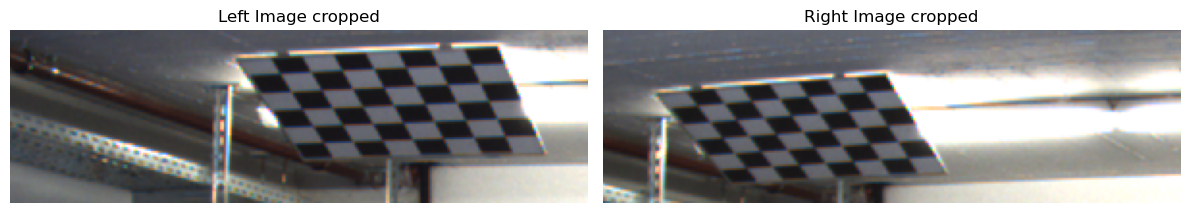

Chessboard detected with size (7, 5) in iteration 1
No chessboards found after iteration 1


In [3]:
# find 13th chessboard
x_1, x_2 = 350, 650
y_1, y_2 = 70, 160
img_02_cropped = img_02.copy()[y_1:y_2,x_1:x_2]
img_03_cropped = img_03.copy()[y_1:y_2,x_1:x_2]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the left image
axes[0].imshow(img_02_cropped)
axes[0].set_title("Left Image cropped")
axes[0].axis("off")

# Display the right image
axes[1].imshow(img_03_cropped)
axes[1].set_title("Right Image cropped")
axes[1].axis("off")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

temp_objpoints, temp_imgpoints_left, temp_imgpoints_right, temp_chessboard_sizes = find_chessboards_together(img_02_cropped, img_03_cropped, chessboard_sizes)

# map image points to original image points
temp_imgpoints_left[0][:,0] += (x_1, y_1)
temp_imgpoints_right[0][:,0] += (x_1, y_1)

imgpoints_left.append(temp_imgpoints_left[0])
imgpoints_right.append(temp_imgpoints_right[0])
objpoints.append(temp_objpoints[0])
detected_chessboard_sizes.append(temp_chessboard_sizes[0])


In [4]:
def fix_chessboard_order(imgpoints_func, index):
    # Get the corners for the specified chessboard index
    corners_func = imgpoints_func[index]
    
    # Flip the corners vertically or horizontally (depending on the issue)
    # This flips the points top-to-bottom for a vertical flip, or left-right for a horizontal flip
    corners_func = corners_func[::-1]  # This reverses the order of the points
    
    # Update the image points list with the corrected order
    imgpoints_func[index] = corners_func
    
    return imgpoints_func

imgpoints_left = fix_chessboard_order(imgpoints_left, 7)

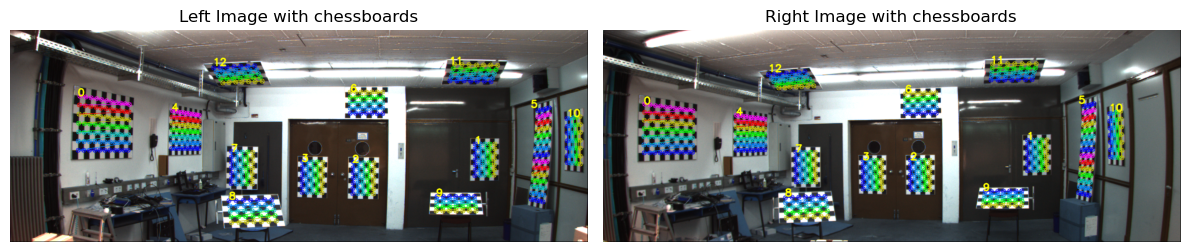

In [5]:
# Function to swap two elements in a list based on their indices
def swap_elements(lst, index1, index2):
    if index1 < 0 or index1 >= len(lst) or index2 < 0 or index2 >= len(lst):
        raise IndexError("Invalid index")
    lst[index1], lst[index2] = lst[index2], lst[index1]
    return lst

# Function to label chessboard on the top left
def label_chessboard(img, corners, idx):
    corners = corners.reshape(-1, 2).astype(np.float32)  # Ensure it's a float32 array

    # Find the corner with the smallest x and y coordinates
    top_left_corner = np.min(corners, axis=0)
    top_left_corner = tuple(top_left_corner)
    top_left_corner = (int(top_left_corner[0]), int(top_left_corner[1]))
        
    # Label the chessboard with its index (1-based index) and size at the top-left corner
    cv2.putText(img, f'{idx}', 
                    top_left_corner,
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    0.8, (255, 255, 0), 2, cv2.LINE_AA)
    return img

# Function to draw chessboards and label them with their index
def draw_chessboards_with_labels(image, imgpoints, chessboard_sizes):
    # Create a copy of the image to visualize chessboards
    visualized_image = image.copy()

    # Draw all the chessboards and label them with their position and size
    for idx, (corners, size) in enumerate(zip(imgpoints, chessboard_sizes)):
        
        # Draw chessboard corners
        cv2.drawChessboardCorners(visualized_image, size, corners, True)
        
        # draw label
        visualized_image = label_chessboard(visualized_image, corners, idx)

    return visualized_image
    # get relevant image and corresponding information
left_image = cv2.imread(img_02_path)
right_image = cv2.imread(img_03_path)


imgpoints_left = swap_elements(imgpoints_left, 6, 7)
imgpoints_left = swap_elements(imgpoints_left, 9, 10)

# Draw chessboards with labels on both left and right images
visualized_left_image = draw_chessboards_with_labels(left_image, imgpoints_left, detected_chessboard_sizes)
visualized_right_image = draw_chessboards_with_labels(right_image, imgpoints_right, detected_chessboard_sizes)

# Visualize the images with drawn chessboards and labels
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Show left image with labeled chessboards
axes[0].imshow(visualized_left_image)
axes[0].set_title(f"Left Image with chessboards")
axes[0].axis('off')

# Show right image with labeled chessboards
axes[1].imshow(visualized_right_image)
axes[1].set_title(f"Right Image with chessboards")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [6]:
import itertools

# Funktion zum Runden und Vergleichen von Matrizen
def compare_matrices(name, calculated, correct):
    calculated_rounded = np.round(calculated, 2)
    correct_rounded = np.round(correct, 2)
    print(f"{name} (calculated):\n{calculated_rounded}")
    print(f"{name} (correct):\n{correct_rounded}")
    print()
    
# get all combinations
def get_flag_combinations(flag_options):
    all_combinations = []
    for r in range(1, len(flag_options) + 1):
        combinations = itertools.combinations(flag_options, r)
        all_combinations.extend(combinations)
    return all_combinations

flag_options_calibrate = [
    (cv2.CALIB_FIX_K1, "cv2.CALIB_FIX_K1"),
    (cv2.CALIB_FIX_K2, "cv2.CALIB_FIX_K2"),
    (cv2.CALIB_FIX_K3, "cv2.CALIB_FIX_K3"),
    (cv2.CALIB_FIX_K4, "cv2.CALIB_FIX_K4"),
    (cv2.CALIB_FIX_K5, "cv2.CALIB_FIX_K5"),
    (cv2.CALIB_FIX_PRINCIPAL_POINT, "cv2.CALIB_FIX_PRINCIPAL_POINT"),
    (cv2.CALIB_ZERO_TANGENT_DIST, "cv2.CALIB_ZERO_TANGENT_DIST"),
    (cv2.CALIB_FIX_ASPECT_RATIO, "cv2.CALIB_FIX_ASPECT_RATIO")
]

flag_combinations_calibrate = get_flag_combinations(flag_options_calibrate)

gray_left = cv2.cvtColor(left_image, cv2.COLOR_RGB2GRAY)
image_size = gray_left.shape[::-1]

# Calibrate a single camera with flag combinations
def calibrate_camera_with_flags(objpoints, imgpoints, image_size, flag_combination):
    flags = 0
    for flag, _ in flag_combination:
        flags |= flag
            # Calibrate camera
    ret, K, D, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, image_size, None, None, flags=flags
    )
    return ret, K, D, rvecs, tvecs

# Example function to test all flag combinations and print results
def test_calibrations(objpoints, imgpoints, image_size, all_combinations):
    # Get all flag combinations
    print(f"Total combinations: {len(all_combinations)}")
    for flag_combination in all_combinations:
        print(f"Testing flag combination: {flag_combination}")
        # Run calibrations
        ret, K, D, rvecs, tvecs = calibrate_camera_with_flags(objpoints, imgpoints, image_size, flag_combination)
        
        print(f"Calibration result: {ret}")
        if ret < 0.14:
            break
    # show flags in last combination
    active_flags = [name for _, name in flag_combination]
    print(f"Active flags: {', '.join(active_flags)}")

print("Testing left camera...")
test_calibrations(objpoints, imgpoints_left, image_size, flag_combinations_calibrate)

# Test right camera calibration
print("\nTesting right camera...")
test_calibrations(objpoints, imgpoints_right, image_size, flag_combinations_calibrate)


Testing left camera...
Total combinations: 255
Testing flag combination: ((32, 'cv2.CALIB_FIX_K1'),)
Calibration result: 0.20914553439443562
Testing flag combination: ((64, 'cv2.CALIB_FIX_K2'),)
Calibration result: 0.1989520737645431
Testing flag combination: ((128, 'cv2.CALIB_FIX_K3'),)
Calibration result: 0.20116429885526496
Testing flag combination: ((2048, 'cv2.CALIB_FIX_K4'),)
Calibration result: 0.2005166881134814
Testing flag combination: ((4096, 'cv2.CALIB_FIX_K5'),)
Calibration result: 0.2005166881134814
Testing flag combination: ((4, 'cv2.CALIB_FIX_PRINCIPAL_POINT'),)
Calibration result: 0.19895432654486642
Testing flag combination: ((8, 'cv2.CALIB_ZERO_TANGENT_DIST'),)
Calibration result: 0.2071757545205528
Testing flag combination: ((2, 'cv2.CALIB_FIX_ASPECT_RATIO'),)
Calibration result: 0.12198768597432208
Active flags: cv2.CALIB_FIX_ASPECT_RATIO

Testing right camera...
Total combinations: 255
Testing flag combination: ((32, 'cv2.CALIB_FIX_K1'),)
Calibration result: 0.165

In [7]:
flags_calib_left = cv2.CALIB_FIX_ASPECT_RATIO
flags_calib_right = cv2.CALIB_FIX_K2

ret_calib_left, K_left, D_left, rvecs_left, tvecs_left = cv2.calibrateCamera(objpoints, imgpoints_left, image_size, None, None, flags = flags_calib_left)
ret_calib_right, K_right, D_right, rvecs_right, tvecs_right = cv2.calibrateCamera(objpoints, imgpoints_right, image_size, None, None, flags = flags_calib_right)

print("Ret (left):", np.round(ret_calib_left,2), "\nRet (right):", np.round(ret_calib_right,2))

# Compare camera matrix
compare_matrices("\nCameraMatrix (left)", K_left, calib_data.K_02)
compare_matrices("CameraMatrix (right)", K_right, calib_data.K_03)

# compare distortion
compare_matrices("Distortion (left)", D_left, calib_data.D_02)
compare_matrices("Distortion (right)", D_right, calib_data.D_03)

Ret (left): 0.12 
Ret (right): 0.14

CameraMatrix (left) (calculated):
[[972.49   0.   689.54]
 [  0.   972.49 255.23]
 [  0.     0.     1.  ]]

CameraMatrix (left) (correct):
[[956.95   0.   693.98]
 [  0.   952.24 238.61]
 [  0.     0.     1.  ]]

CameraMatrix (right) (calculated):
[[895.42   0.   687.05]
 [  0.   901.75 255.54]
 [  0.     0.     1.  ]]
CameraMatrix (right) (correct):
[[901.1    0.   698.29]
 [  0.   897.06 237.74]
 [  0.     0.     1.  ]]

Distortion (left) (calculated):
[[-0.27 -0.    0.   -0.    0.06]]
Distortion (left) (correct):
[-0.38  0.21  0.    0.   -0.07]

Distortion (right) (calculated):
[[-0.28  0.   -0.   -0.    0.07]]
Distortion (right) (correct):
[-0.37  0.19 -0.    0.   -0.06]



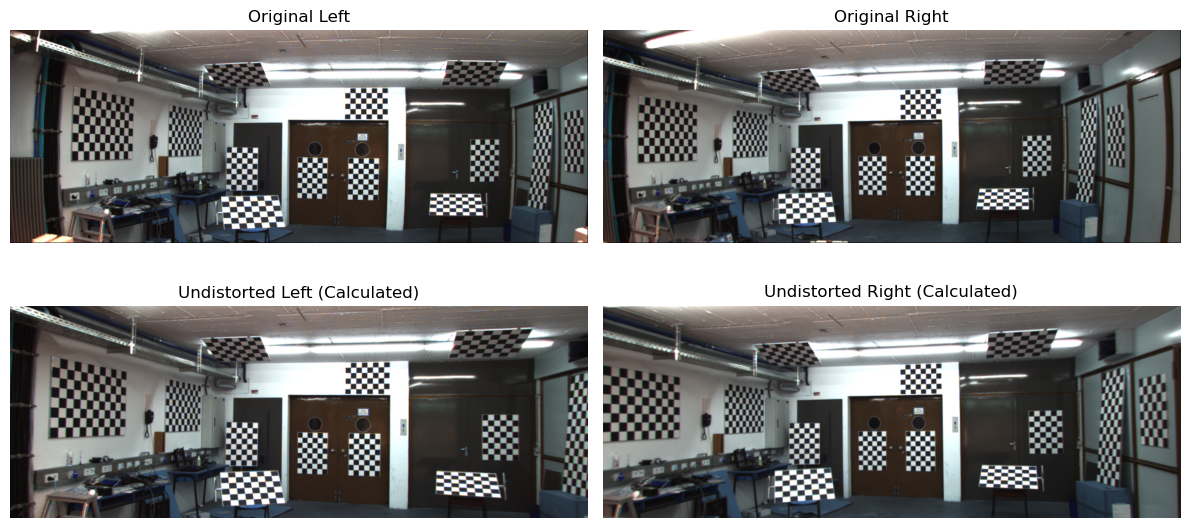

In [8]:
# plot undistorted images
def plot_undistorted_images(left_original, right_original, left_calculated, right_calculated):
    fig, axs = plt.subplots(2, 2, figsize=(12, 6))

    # left
    axs[0, 0].imshow(left_original)
    axs[0, 0].set_title("Original Left")
    axs[0, 0].axis("off")

    axs[1, 0].imshow(left_calculated)
    axs[1, 0].set_title("Undistorted Left (Calculated)")
    axs[1, 0].axis("off")

    # right
    axs[0, 1].imshow(right_original)
    axs[0, 1].set_title("Original Right")
    axs[0, 1].axis("off")

    axs[1, 1].imshow(right_calculated)
    axs[1, 1].set_title("Undistorted Right (Calculated)")
    axs[1, 1].axis("off")

    plt.tight_layout()
    plt.show()
# K_left_new, roi_left = cv2.getOptimalNewCameraMatrix(K_left,D_left,image_size,1,image_size)
# K_right_new, roi_right = cv2.getOptimalNewCameraMatrix(K_right,D_right,image_size,1,image_size)

# x_l,y_l,w_l,h_l = roi_left
# x_r,y_r,w_r,h_r = roi_right
# undistorted_left = cv2.undistort(left_image, K_left, D_left, None, K_left_new)[y_l:y_l+h_l, x_l:x_l+w_l]
# undistorted_right = cv2.undistort(right_image, K_right, D_right, None, K_right_new)[y_r:y_r+h_r, x_r:x_r+w_r]
undistorted_left_old = cv2.undistort(left_image, K_left, D_left)
undistorted_right_old = cv2.undistort(right_image, K_right, D_right)

plot_undistorted_images(left_image, right_image, undistorted_left_old, undistorted_right_old)# , undistorted_left, undistorted_right)

In [9]:
# find good flags for stereo calibration

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-5)
# define flag options
flag_options_stereo = [
    (cv2.CALIB_FIX_INTRINSIC, "cv2.CALIB_FIX_INTRINSIC"),
    (cv2.CALIB_FIX_ASPECT_RATIO, "cv2.CALIB_FIX_ASPECT_RATIO"),
    (cv2.CALIB_ZERO_TANGENT_DIST, "cv2.CALIB_ZERO_TANGENT_DIST"),
    (cv2.CALIB_USE_INTRINSIC_GUESS, "cv2.CALIB_USE_INTRINSIC_GUESS"),
    (cv2.CALIB_SAME_FOCAL_LENGTH, "cv2.CALIB_SAME_FOCAL_LENGTH"),
    (cv2.CALIB_RATIONAL_MODEL, "cv2.CALIB_RATIONAL_MODEL"),
    (cv2.CALIB_FIX_K3, "cv2.CALIB_FIX_K3"),
    (cv2.CALIB_FIX_K4, "cv2.CALIB_FIX_K4"),
    (cv2.CALIB_FIX_K5, "cv2.CALIB_FIX_K5")
]



# stereo calibrate 
def stereo_calibrate_with_flags(objpoints, imgpoints_left, imgpoints_right, image_size, flag_combination):
    # Wandle die Flag-Kombination in eine Bitmaske um
    flags = 0
    for flag, _ in flag_combination:
        flags |= flag

    ret, mtx1, dist1, mtx2, dist2, R, T, E, F = cv2.stereoCalibrate(
        objpoints, imgpoints_left, imgpoints_right, K_left, D_left, K_right, D_right,
        image_size, criteria=criteria,
        flags=flags
    )

    return ret, mtx1, dist1, mtx2, dist2, R, T, E, F

all_combinations_stereo = get_flag_combinations(flag_options_stereo)

for flag_combination in all_combinations_stereo:
    print(f"Testing flag combination: {flag_combination}")
    ret, mtx1, dist1, mtx2, dist2, R, T, E, F = stereo_calibrate_with_flags(
        objpoints, imgpoints_left, imgpoints_right, image_size, flag_combination
    )
    print(f"Calibration result: {ret}")

    if ret < 0.13:
        break

# show flags in last combination
active_flags = [name for _, name in flag_combination]
print(f"Active flags: {', '.join(active_flags)}")

Testing flag combination: ((256, 'cv2.CALIB_FIX_INTRINSIC'),)
Calibration result: 0.44396284352668297
Testing flag combination: ((2, 'cv2.CALIB_FIX_ASPECT_RATIO'),)
Calibration result: 0.1400084647685428
Testing flag combination: ((8, 'cv2.CALIB_ZERO_TANGENT_DIST'),)
Calibration result: 0.13314474234425364
Testing flag combination: ((1, 'cv2.CALIB_USE_INTRINSIC_GUESS'),)
Calibration result: 0.12841517449977552
Active flags: cv2.CALIB_USE_INTRINSIC_GUESS


In [10]:
correct_values = False

# Stereo calibration to get the relative rotation and translation between the cameras
flags_stereo_calib = cv2.CALIB_FIX_ASPECT_RATIO
# Perform stereo calibration
if correct_values:
    ret, K_left_stereo, D_left_stereo, K_right_stereo, D_right_stereo, R, T, E, F = cv2.stereoCalibrate(
    objpoints, imgpoints_left, imgpoints_right, calib_data.K_02, calib_data.D_02, calib_data.K_03, calib_data.D_03,
   image_size, flags=flags_stereo_calib, criteria=criteria
)
else:
    ret, K_left_stereo, D_left_stereo, K_right_stereo, D_right_stereo, R, T, E, F = cv2.stereoCalibrate(
        objpoints, imgpoints_left, imgpoints_right, K_left, D_left, K_right, D_right,
        image_size, flags=flags_stereo_calib, criteria=criteria
    )
# R: Rotation matrix between the two cameras
# T: Translation vector between the two cameras
# E: Essential matrix
# F: Fundamental matrix
print("Ret:", np.round(ret,2)) # 0.13 for true values
print("\nRotation:\n", np.round(R,2))
print("\nTranslation:\n", np.round(T,2))

Ret: 0.13

Rotation:
 [[ 1.    0.02 -0.01]
 [-0.02  1.    0.  ]
 [ 0.01  0.    1.  ]]

Translation:
 [[-5.35]
 [ 0.06]
 [-0.06]]


In [11]:
# Get the rectification matrices and projection matrices
rectify_flags = cv2.CALIB_ZERO_DISPARITY

R2, R3, P2, P3, Q, roi1, roi2 = cv2.stereoRectify(
        K_left_stereo, D_left_stereo, K_right_stereo, D_right_stereo, image_size, R, T, flags = rectify_flags, alpha = 1
)

# R2, R3: Rotation matrices for the left and right cameras
# P2, P3: Projection matrices for the left and right cameras
# Q: Disparity-to-depth mapping matrix (useful for 3D reconstruction)

# Generate rectification maps
if correct_values:
    map1_left, map2_left = cv2.initUndistortRectifyMap(
        calib_data.K_02, calib_data.D_02, calib_data.R_rect_02, calib_data.P_rect_02, image_size, cv2.CV_32FC1  # Use 32-bit floating point maps
    )

    map1_right, map2_right = cv2.initUndistortRectifyMap(
        calib_data.K_03, calib_data.D_03, calib_data.R_rect_03, calib_data.P_rect_03, image_size, cv2.CV_32FC1  # Use 32-bit floating point maps
    )
else:
    map1_left, map2_left = cv2.initUndistortRectifyMap(
        K_left_stereo, D_left_stereo, R2, P2, image_size, cv2.CV_32FC1  # Use 32-bit floating point maps
    )

    map1_right, map2_right = cv2.initUndistortRectifyMap(
        K_right_stereo, D_right_stereo, R3, P3, image_size, cv2.CV_32FC1  # Use 32-bit floating point maps
    )

# Apply the rectification maps
assert(roi1 != (0,0,0,0) and roi2 != (0,0,0,0))
rectified_left = cv2.remap(left_image, map1_left, map2_left, cv2.INTER_LINEAR)
rectified_right = cv2.remap(right_image, map1_right, map2_right, cv2.INTER_LINEAR)
rectified_left = rectified_left[roi1[1]:roi1[1]+roi1[3], roi1[0]:roi1[0]+roi1[2]]
rectified_right = rectified_right[roi2[1]:roi2[1]+roi2[3], roi2[0]:roi2[0]+roi2[2]]

compare_matrices("Rectification (left)", R2, calib_data.R_rect_02)
compare_matrices("Projection (left)", P2, calib_data.P_rect_02)
compare_matrices("Rectification (right)", R3, calib_data.R_rect_03)
compare_matrices("Projection (right)", P3, calib_data.P_rect_03)



Rectification (left) (calculated):
[[ 1.    0.01 -0.  ]
 [-0.01  1.    0.  ]
 [ 0.    0.    1.  ]]
Rectification (left) (correct):
[[ 1.    0.02 -0.01]
 [-0.02  1.   -0.  ]
 [ 0.01  0.    1.  ]]

Projection (left) (calculated):
[[582.28   0.   640.5    0.  ]
 [  0.   582.28 199.81   0.  ]
 [  0.     0.     1.     0.  ]]
Projection (left) (correct):
[[ 7.0705e+02  0.0000e+00  6.0408e+02  4.5760e+01]
 [ 0.0000e+00  7.0705e+02  1.8051e+02 -3.5000e-01]
 [ 0.0000e+00  0.0000e+00  1.0000e+00  0.0000e+00]]

Rectification (right) (calculated):
[[ 1.   -0.01  0.01]
 [ 0.01  1.    0.  ]
 [-0.01  0.    1.  ]]
Rectification (right) (correct):
[[ 1.   -0.01  0.02]
 [ 0.01  1.   -0.  ]
 [-0.02  0.    1.  ]]

Projection (right) (calculated):
[[ 5.82280e+02  0.00000e+00  6.40500e+02 -3.11296e+03]
 [ 0.00000e+00  5.82280e+02  1.99810e+02  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  1.00000e+00  0.00000e+00]]
Projection (right) (correct):
[[ 707.05    0.    604.08 -334.11]
 [   0.    707.05  180.51    2.3

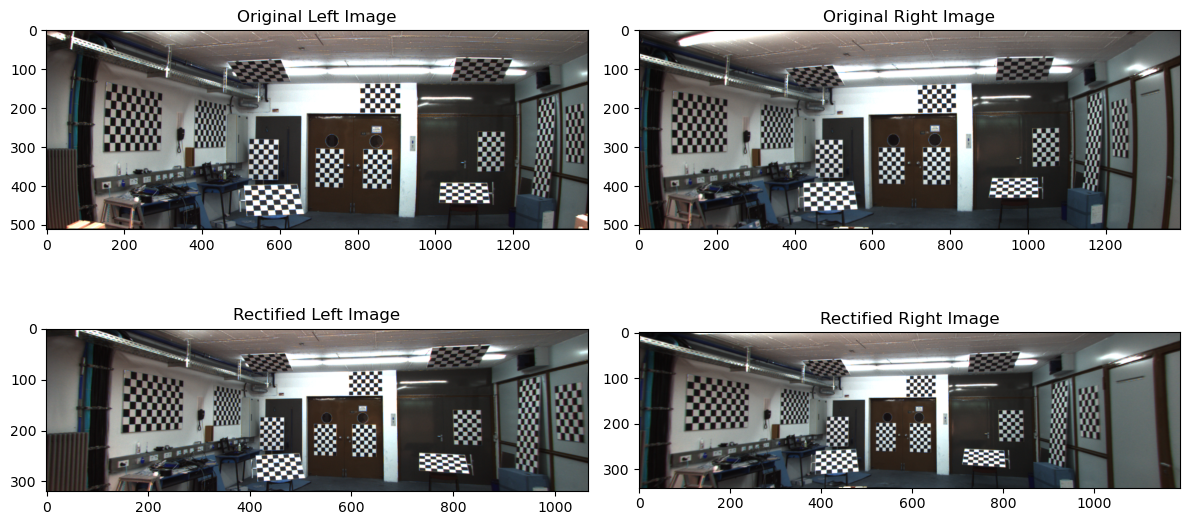

In [12]:
import matplotlib.pyplot as plt

# Plot the original and rectified images
fig, ax = plt.subplots(2, 2, figsize=(12, 6))

# Undistorted Left and Right images
ax[0, 0].imshow(left_image)
ax[0, 0].set_title('Original Left Image')
ax[0, 1].imshow(right_image)
ax[0, 1].set_title('Original Right Image')

# Rectified Left and Right images
ax[1, 0].imshow(rectified_left)
ax[1, 0].set_title('Rectified Left Image')
ax[1, 1].imshow(rectified_right)
ax[1, 1].set_title('Rectified Right Image')

plt.tight_layout()
plt.show()


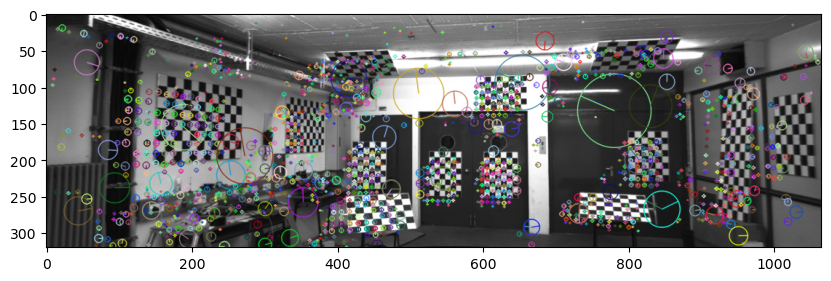

In [21]:
# SIFT-Detektor erstellen
sift = cv2.SIFT_create()
rectified_left_gray = cv2.cvtColor(rectified_left, cv2.COLOR_RGB2GRAY)
rectified_right_gray = cv2.cvtColor(rectified_right, cv2.COLOR_RGB2GRAY)
# Keypoints und Deskriptoren extrahieren
kp1, des1 = sift.detectAndCompute(rectified_left_gray, None)
kp2, des2 = sift.detectAndCompute(rectified_right_gray, None)

kp_img = cv2.drawKeypoints(rectified_left_gray, kp2, rectified_right_gray, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize = (10,10))
plt.imshow(kp_img)


In [22]:
#Implement bf matcher here

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

matches = bf.match(des1, des2)

# Sort them in the order of their distance (i.e. best matches first).
matches = sorted(matches, key = lambda x:x.distance)

nb_matches = 200

good = []
pts1 = []
pts2 = []

for m in matches[:nb_matches]:
    good.append(m)
    pts1.append(kp1[m.queryIdx].pt)
    pts2.append(kp2[m.trainIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
    
"""
Implement findFundamentalMat here:
"""
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# We select only inlier points
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

(341, 1190)


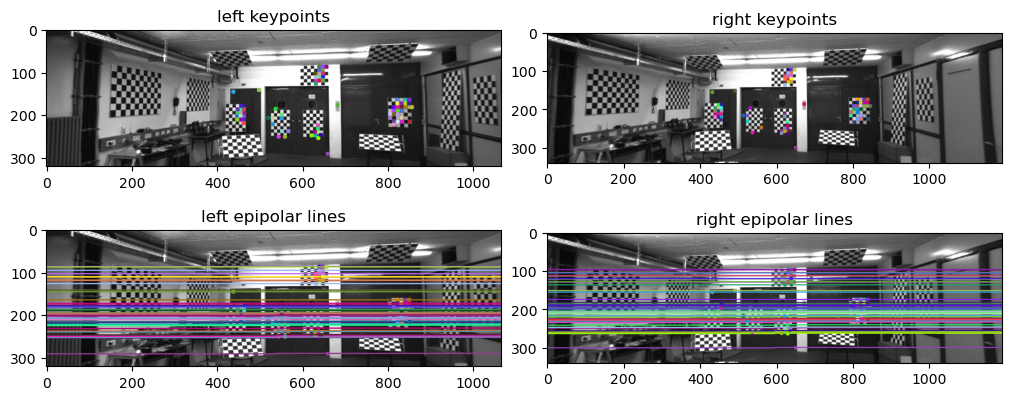

In [ ]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,2)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2 ,F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(rectified_left_gray, rectified_right_gray, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(rectified_right_gray, rectified_left_gray, lines2, pts2, pts1)

fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(10,4))
axs[0, 0].imshow(img4)
axs[0, 0].set_title('left keypoints')
axs[0, 1].imshow(img6)
axs[0, 1].set_title('right keypoints')
axs[1, 0].imshow(img5)
axs[1, 0].set_title('left epipolar lines')
axs[1, 1].imshow(img3)
axs[1, 1].set_title('right epipolar lines')
plt.show()